# Skeleton pytorch with PyPSA data

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
# from torchvision.utils import make_grid
import pandas as pd

from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dir_root = Path("../") # go to root of git repo
dir_data = dir_root / "data"
dir_export= dir_data /"ml"
dir_models = dir_root / "models"
param_save = "003_01_simplest"

filename_inputs = dir_export / "input.P"
filename_outputs = dir_export / "output.P"

for fn in [filename_inputs, filename_outputs]:
    print(f"{fn}: {'Exists' if fn.exists() else 'Missing'}")

../data/ml/input.P: Exists
../data/ml/output.P: Exists


In [3]:
learning_rate =1e-3
batch_size =128
num_epochs = int(3e3)

### Load data

In [19]:
df_input = pd.read_pickle(filename_inputs)
df_output = pd.read_pickle(filename_outputs).fillna(0)

x_train = torch.from_numpy(df_input.values.astype("float32"))
y_train = torch.from_numpy(df_output.values.astype("float32"))
x_train =(x_train - x_train.mean(dim = 0))/x_train.std(dim = 0)
y_train = (y_train - y_train.mean(dim = 0))/y_train.std(dim = 0)

n_input = x_train.shape[1]
n_output = y_train.shape[1]
n_samples = x_train.shape[0]

(n_input,n_output)
# train_loader = load

(219, 881)

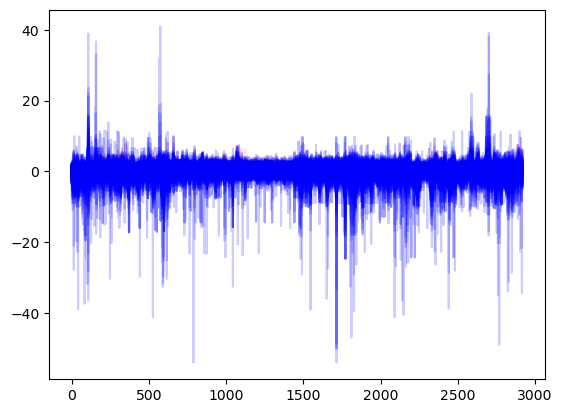

In [23]:
_=plt.plot(x_train, "r", alpha = 0.1) # [:,38:192]
_=plt.plot(y_train, "b", alpha = 0.2) # [:,38:192]


### Define Model

In [11]:
## Full model
class PowerModel(nn.Module):
    """Feedfoward neural network (0 layers)"""
    def __init__(self, in_size,  out_size, hidden_size=None):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        # output layer
        self.linear5 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # # Apply activation function
        out = F.relu(out)
        # # Get predictions using output layer
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out
    
    # def training_step(self, batch):
    #     inputs, targets = batch 
    #     out = self(inputs)                  # Generate predictions
    #     loss = F.cross_entropy(out, targets) # Calculate loss
    #     return loss
    
    # def validation_step(self, batch):
    #     inputs, targets = batch 
    #     out = self(inputs)                    # Generate predictions
    #     loss = F.cross_entropy(out, targets)   # Calculate loss
    #     # acc = accuracy(out, labels)           # Calculate accuracy
    #     return loss

        
    # def validation_epoch_end(self, outputs):
    #     batch_losses = outputs
    #     epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    #     # batch_accs = [x['val_acc'] for x in outputs]
    #     # epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    #     return  epoch_loss.item()

    # def epoch_end(self,epoch,result):
    #     print(f"Epoch [{epoch}], val_loss: { result['val_loss'] :.4f}") #, val_acc: {result['val_acc']:.4f}")
        

### Instantiate and run

In [ ]:
# Logistic regression model
model =  PowerModel(n_input,n_output,hidden_size=512)
# Loss and optimizer
# nn.CrossEntropyLoss() computes softmax internally
criterion = nn.MSELoss()  
# criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
np.arange(y_train.shape[1])[y_train.isnan().any(axis=0)]

array([ 49,  52,  59, 476, 478, 480, 482, 484, 486, 488, 490, 493, 495,
       497, 499, 502, 504, 507, 508, 510, 512, 514, 517, 519, 521, 523,
       646, 709, 865, 866])

In [35]:
# Train the model
losses=[]
for epoch in range(num_epochs):

    # Forward pass
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # model.epoch_end(epoch,loss)
    losses.append(loss.item())
    if (epoch+1) % 100 == 0:
        print(f"Epoch [{epoch+1}], Loss: { loss.item() :.5f}")
        # print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))



KeyboardInterrupt: 

### Export

In [ ]:
# Save and load the entire model.
torch.save(model, dir_models/f'{param_save}_model.ckpt')
# model = torch.load('model.ckpt')

# Save and load only the model parameters (recommended).
torch.save(model.state_dict(), dir_models/f'{param_save}_params.ckpt')
# resnet.load_state_dict(torch.load('params.ckpt'))

### Plot training

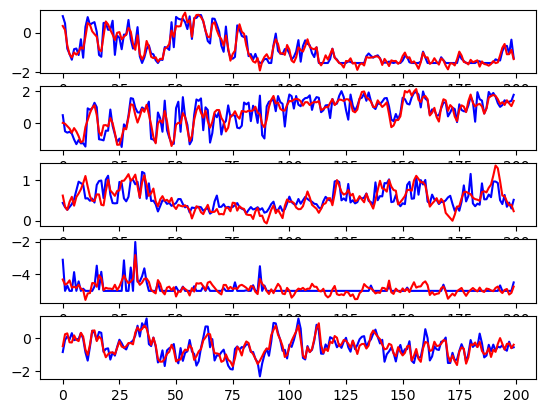

In [155]:
with torch.no_grad():
    fig,axes =plt.subplots(5)
    for i, ax in enumerate(axes):
        ax.plot(y_train[:200,i+10],"b")
        ax.plot(outputs[:200,i+10],"r")

In [149]:
# losses_linear = losses
# losses_nn64=losses
losses_nn64x64=losses

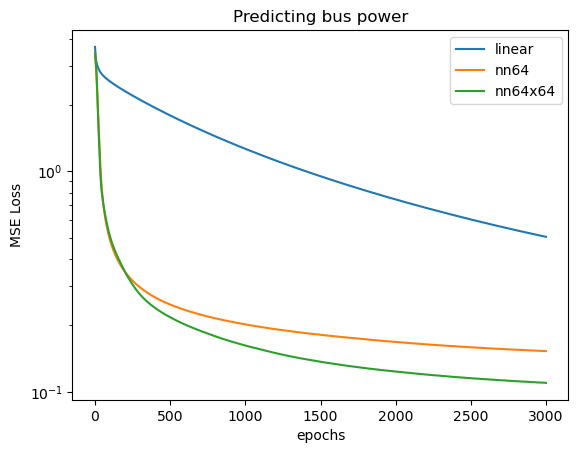

In [164]:
plt.plot(losses_linear,label="linear")
plt.plot(losses_nn64,label="nn64")
plt.plot(losses_nn64x64,label="nn64x64")
plt.legend()
plt.ylabel("MSE Loss")
plt.xlabel("epochs")
plt.title("Predicting bus power")
plt.yscale('log')